# Compare seasonal cycles

We directly model NEE, but let's comapre the seasonal cycle of the modelled NEE versus subtracting ER from GPP.

In [1]:
import os
import odc.geo
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from odc.geo.xr import assign_crs
from matplotlib.colors import ListedColormap

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _prediction import allNaN_arg
from _utils import xr_rasterize

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

/g/data/xc0/project/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:788: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/xc0/project/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:788: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/xc0/project/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:788: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

distributed.nanny.memory - WARNING - Ignoring provided memory limit 538696993792 due to system memory limit of 124.00 GiB
/g/data/xc0/project/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:788: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/xc0/project/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:788: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/xc0/project/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:788: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/xc0/project/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:788: FutureWarning: Dask configuration key 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 26,Total memory: 124.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43285,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 26
Started: Just now,Total memory: 124.00 GiB
Comm: tcp://127.0.0.1:46131,Total threads: 26
Dashboard: /proxy/44713/status,Memory: 124.00 GiB
Nanny: tcp://127.0.0.1:34639,


## Analysis Parameters

In [5]:
var = 'NEE'
version='v2.1'
base = f'/g/data/xc0/project/AusEFlux/'

## Open predictions

In [11]:
# ----NEE-------------------------------
folder = base+f'results/AusEFlux/{version}/NEE/'
files = [f'{folder}/{i}' for i in os.listdir(folder) if i.endswith(".nc")]
files.sort()
nee = xr.open_mfdataset(files).sel(time=slice('2003','2021'))
nee = assign_crs(nee, crs='EPSG:4326')
nee.attrs['nodata'] = np.nan
# nee = nee[['NEE_median']]

# ----GPP-------------------------------
folder = base+f'results/AusEFlux/{version}/GPP/'
files = [f'{folder}/{i}' for i in os.listdir(folder) if i.endswith(".nc")]
files.sort()
gpp = xr.open_mfdataset(files).sel(time=slice('2003','2021'))
gpp = assign_crs(gpp, crs='EPSG:4326')
gpp.attrs['nodata'] = np.nan
# gpp = gpp[['GPP_median']]

# ----ER-------------------------------
folder = base+f'results/AusEFlux/{version}/ER/'
files = [f'{folder}/{i}' for i in os.listdir(folder) if i.endswith(".nc")]
files.sort()
er = xr.open_mfdataset(files).sel(time=slice('2003','2021'))
er = assign_crs(er, crs='EPSG:4326')
er.attrs['nodata'] = np.nan
# er = er[['ER_median']]


### open fire

In [12]:
# fire = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/FireEmissions_10km_monthly_2003_2022.nc').sel(time=slice('2003','2021'))
# fire = fire.sum(['x', 'y'])
# fire = fire*12

## Convert to PgC/year

Zoom out to 5km resolution to speed things up

In [13]:
grid = nee.odc.geobox.to_crs('EPSG:3577')
grid = grid.zoom_out(factor=5)

nee = nee.odc.reproject(how=grid, resampling='bilinear').compute()
gpp = gpp.odc.reproject(how=grid, resampling='bilinear').compute()
er = er.odc.reproject(how=grid, resampling='bilinear').compute()

/g/data/xc0/project/AusEFlux/env/py310/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [14]:
area_per_pixel = nee['NEE_median'].odc.geobox.resolution.x**2

nee = nee * area_per_pixel * 1e-15 * 12 # (pgC/year)
gpp = gpp * area_per_pixel * 1e-15 * 12 # (pgC/year)
er = er * area_per_pixel * 1e-15 * 12 # (pgC/year)

In [15]:
nee_sub = er['ER_median'] - gpp['GPP_median']
nee_sub.name = 'NEE (ER-GPP)'

## Plot climatology

In [16]:
y_nee = nee['NEE_median'].groupby('time.month').mean().sum(['x','y']).values
y_upper = nee['NEE_25th_percentile'].groupby('time.month').mean().sum(['x','y']).values
y_lower = nee['NEE_75th_percentile'].groupby('time.month').mean().sum(['x','y']).values

y_nee_sub = nee_sub.groupby('time.month').mean().sum(['x','y']).values
y_gpp = gpp['GPP_median'].groupby('time.month').mean().sum(['x','y']).values
y_er = er['ER_median'].groupby('time.month').mean().sum(['x','y']).values

x = range(1,13)

# ds_fire_1d = nee.mean(['x','y']) + fire
# # ds_fire_1d.drop(['spatial_ref']).to_dataframe(name='NEE+fire')
# y_fire = ds_fire_1d.groupby('time.month').mean()
# fire_clim = fire.groupby('time.month').mean()

### Plot NEE

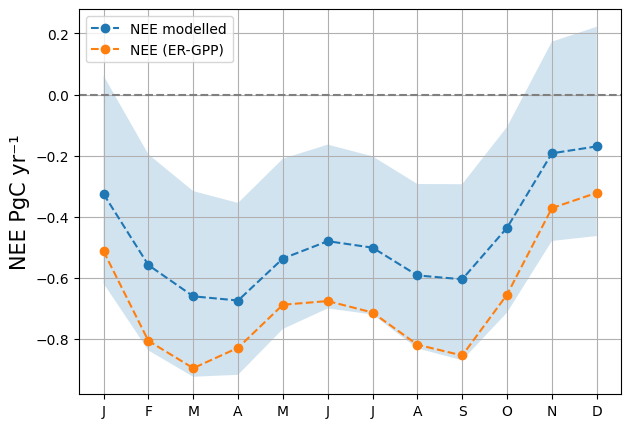

In [17]:

fig,ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(x, y_nee, marker='o', linestyle='--', label='NEE modelled')
ax.fill_between(x, y_lower, y_upper, alpha=0.2)
ax.axhline(0, c='grey', linestyle='--')
ax.plot(x, y_nee_sub, marker='o', linestyle='--', label='NEE (ER-GPP)')
# ax.fill_between(x, y_lower+fire_clim, y_upper+fire_clim, alpha=0.2)

ax.legend(loc='best')
ax.set_xticks(range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]) 
ax.set_ylabel(var+' PgC yr⁻¹', fontsize=15)
ax.grid()
plt.savefig(f'{base}results/figs/NEE_modelled_vs_subtracted.png', bbox_inches='tight', dpi=300)

## Climatologies per biome

In [18]:
import warnings
warnings.filterwarnings("ignore")

er_clim_mean = er.groupby('time.month').mean()
gpp_clim_mean = gpp.groupby('time.month').mean()
nee_clim_mean = nee.groupby('time.month').mean()
nee_sub_clim_mean = nee_sub.groupby('time.month').mean()

In [19]:
bio = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.nc'), crs='EPSG:4326')
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

In [20]:
def make_mask(xx, index):
    mask = bio.odc.reproject(how=xx.odc.geobox, resampling='nearest')
    mask = mask.astype(int)
    mask['x'] = np.array([round(i,6) for i in mask.x.values])
    mask['y'] = np.array([round(i,6) for i in mask.y.values])
    mask = xr.where(mask==index, 1, 0)
    return mask

def round_coords(ds):
    ds['x'] = np.array([round(i,6) for i in ds.x.values])
    ds['y'] = np.array([round(i,6) for i in ds.y.values])
    return ds

In [21]:
# Dictionary to save results 
er_results = {}
for index, row in gdf.iterrows():
    index=index+1
    print(row['region_name'])
    datasets = {}
    
    ds_mask = make_mask(er, index)
    
    dss = round_coords(er_clim_mean).where(ds_mask)
        
    datasets.update({
                'This Study ER':dss,
                }
               )
    # Append results to a dictionary using the attribute
    # column as an key
    er_results.update({row['region_name']: datasets})

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


In [22]:
# Dictionary to save results 
gpp_results = {}
for index, row in gdf.iterrows():
    index=index+1
    print(row['region_name'])
    datasets = {}
    
    ds_mask = make_mask(gpp, index)
    
    dss = round_coords(gpp_clim_mean).where(ds_mask)
        
    datasets.update({
                'This Study GPP':dss,
                }
               )
    # Append results to a dictionary using the attribute
    # column as an key
    gpp_results.update({row['region_name']: datasets})

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


In [23]:
# Dictionary to save results 
nee_results = {}
for index, row in gdf.iterrows():
    index=index+1
    print(row['region_name'])
    datasets = {}
    
    ds_mask = make_mask(nee, index)
    
    dss = round_coords(nee_clim_mean).where(ds_mask)
        
    datasets.update({
                'This Study NEE' : dss,
                }
               )
    # Append results to a dictionary using the attribute
    # column as an key
    nee_results.update({row['region_name']: datasets})

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


### Plot

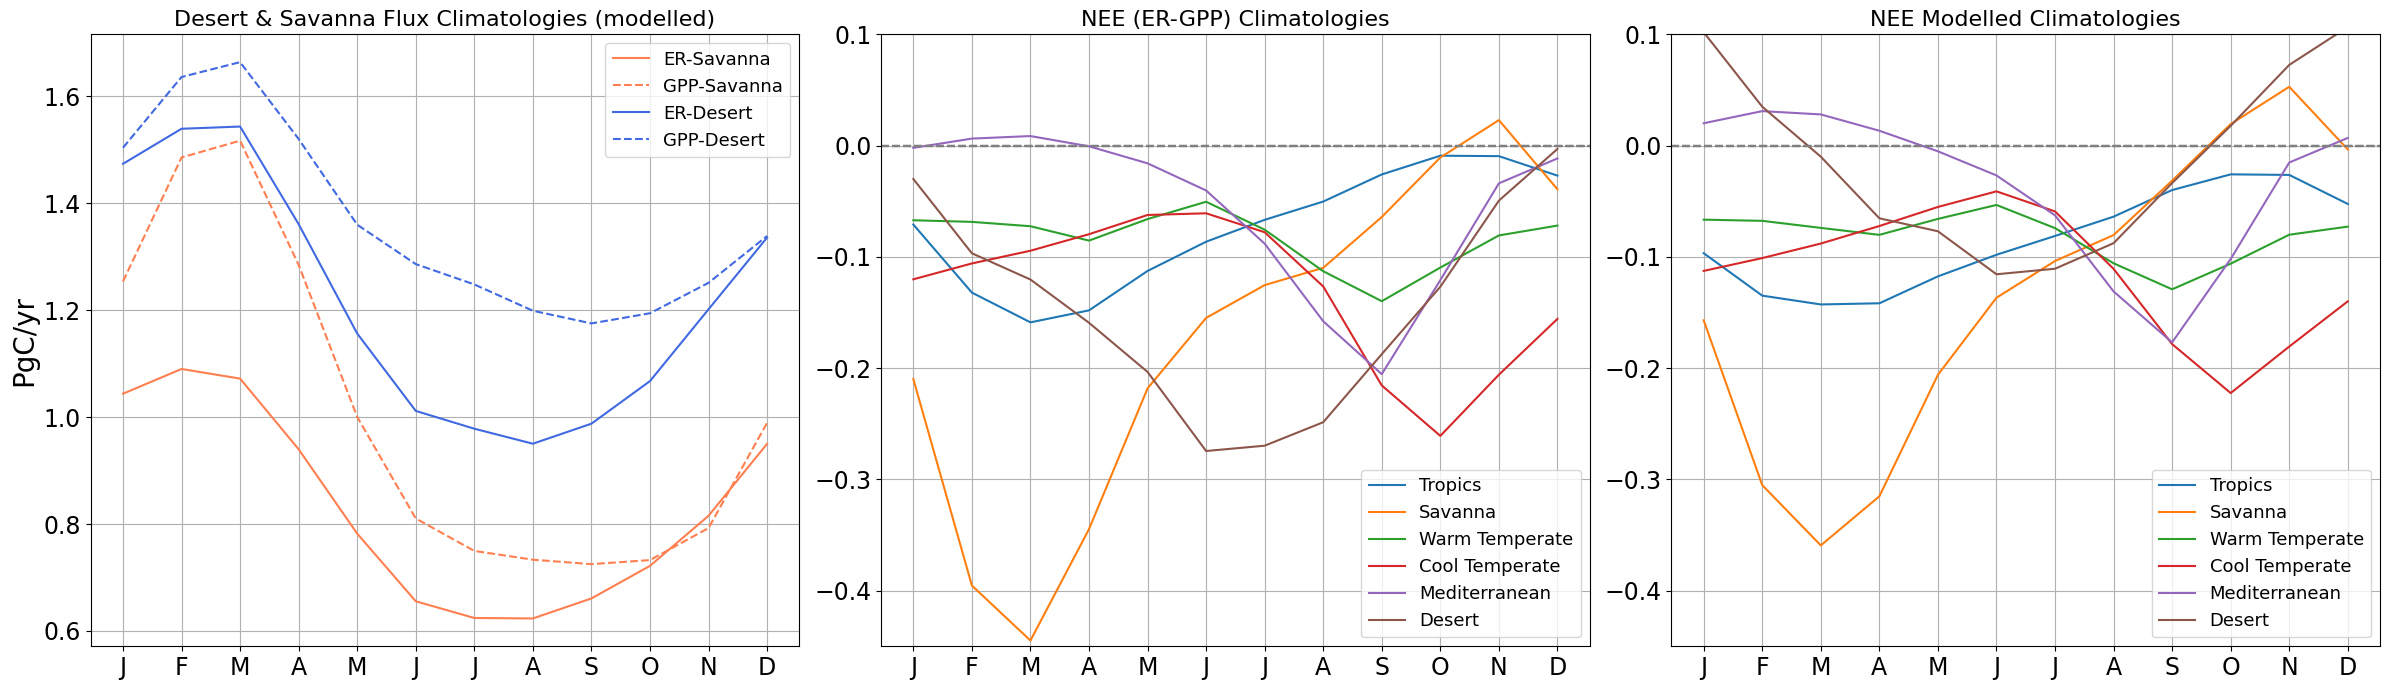

In [28]:
regions = ['Tropics',
'Savanna',
'Warm Temperate',
'Cool Temperate',
'Mediterranean',
'Desert']

fig, ax = plt.subplots(1,3, figsize=(24,7))
for i in regions:
    
    subtract =  er_results[i]['This Study ER']['ER_median'].sum(['x','y']) - gpp_results[i]['This Study GPP']['GPP_median'].sum(['x','y'])
    subtract.plot(label=i, ax=ax[1])
    ax[1].legend(fontsize=13)
    ax[1].set_title('NEE (ER-GPP) Climatologies', fontsize=16)
    ax[1].set_ylabel('')
    ax[1].tick_params(axis='y', labelsize=17)
    ax[1].set_xlabel('')
    ax[1].set_xticks(range(1,13))
    ax[1].set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=17)
    ax[1].axhline(0, c='grey', linestyle='--')
    ax[1].set_ylim(-0.45,0.1)

for i in regions:
    
    subtract =  nee_results[i]['This Study NEE']['NEE_median'].sum(['x','y'])
    subtract.plot(label=i, ax=ax[2])
    ax[2].legend(fontsize=13)
    ax[2].set_title('NEE Modelled Climatologies', fontsize=16)
    ax[2].set_ylabel('')
    ax[2].tick_params(axis='y', labelsize=17)
    ax[2].set_xlabel('')
    ax[2].set_xticks(range(1,13))
    ax[2].set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=17)
    ax[2].axhline(0, c='grey', linestyle='--')
    ax[2].set_ylim(-0.45,0.1)


er_results['Savanna']['This Study ER']['ER_median'].sum(['x','y']).plot(ax=ax[0], label='ER-Savanna', c='coral')
gpp_results['Savanna']['This Study GPP']['GPP_median'].sum(['x','y']).plot(ax=ax[0], label='GPP-Savanna', c='coral', linestyle='--')

er_results['Desert']['This Study ER']['ER_median'].sum(['x','y']).plot(ax=ax[0], label='ER-Desert',c='royalblue' )
gpp_results['Desert']['This Study GPP']['GPP_median'].sum(['x','y']).plot(ax=ax[0], label='GPP-Desert',  c='royalblue', linestyle='--')

ax[0].legend(fontsize=13)
ax[0].set_title('Desert & Savanna Flux Climatologies (modelled)', fontsize=16)
ax[0].set_ylabel('PgC/yr', fontsize=20)
ax[0].tick_params(axis='y', labelsize=17)
ax[0].set_xlabel('')
ax[0].set_xticks(range(1,13))
ax[0].set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=17)
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.tight_layout()

plt.savefig(f'{base}results/figs/NEE_modelled_vs_subtracted_biome.png', bbox_inches='tight', dpi=300)  